# Resonant Tunneling Diode (RTD) Simulation
## Non-Equilibrium Green's Function (NEGF) Formalism in Julia
*By IDIRENE Daris*
This notebook implements a quantum transport simulation of a Resonant Tunneling Diode using the NEGF method.

In [1]:
# Load required packages
using LinearAlgebra
using SparseArrays
using Plots
using Printf
using Peaks

# Set plot backend
gr()

Plots.GRBackend()

In [2]:
# Fundamental constants (SI units)
const ħ_SI = 1.0545718e-34      # Reduced Planck constant [J·s]
const m0_SI = 9.10938e-31       # Electron rest mass [kg]
const e_SI = 1.6021766e-19      # Elementary charge [C]
const kB_eV = 8.617333e-5       # Boltzmann constant [eV/K]
# useful for kinetic energy calculations
const ħ2_over_2m0 = (ħ_SI^2 / (2 * m0_SI)) / (e_SI * 1e-18)  # ≈ 0.0381 eV·nm²

0.038099836176479086

## Device Structure Definition
Basically giving a structure to the model of the device.
We define a `DeviceParameters` struct to hold all simulation parameters. The RTD consists of:
- Source region
- First barrier
- Quantum well
- Second barrier
- Drain region
Keep in mind all units will be in nanometers.

In [3]:
# Device structure
struct DeviceParameters
    N::Int              # N° of grid points
    L::Float64          # device length [nm]
    a::Float64          # spacing [nm]
    x::Vector{Float64}  # Position array
    
    m_eff::Float64
    
    barrier_height::Float64
    barrier_width::Float64
    well_width::Float64
    
    t::Float64
    
    T::Float64
    E_F::Float64
end


function DeviceParameters(;
    N::Int = 200,
    L::Float64 = 50.0,
    m_eff::Float64 = 0.067,
    barrier_height::Float64 = 0.3,
    barrier_width::Float64 = 3.0,
    well_width::Float64 = 5.0,
    T::Float64 = 300.0,
    E_F::Float64 = 0.1
)
    a = L / (N - 1)
    x = collect(range(0, L, length=N))
    
    # Hopping parameter
    t = ħ2_over_2m0 / (m_eff * a^2)
    
    return DeviceParameters(N, L, a, x, m_eff, barrier_height, 
                           barrier_width, well_width, t, T, E_F)
end

# Create default device
device = DeviceParameters()

println("Device Parameters:")
println("Grid points N = $(device.N)")
println("Device length L = $(device.L) nm")
println("Grid spacing a = $(round(device.a, digits=4)) nm")
println("Effective mass m* = $(device.m_eff) m₀")
println("Hopping parameter t = $(round(device.t, digits=4)) eV")
println("Barrier height = $(device.barrier_height) eV")
println("Temperature = $(device.T) K")

Device Parameters:
Grid points N = 200
Device length L = 50.0 nm
Grid spacing a = 0.2513 nm
Effective mass m* = 0.067 m₀
Hopping parameter t = 9.0077 eV
Barrier height = 0.3 eV
Temperature = 300.0 K


## Potential Profile

The potential profile $U(x)$ defines the double-barrier structure. Under applied bias $V$, $U$ potential tilts, modeling a uniform electric field across the device.

In [4]:
function create_equilibrium_potential(dev::DeviceParameters)
    U = zeros(dev.N)
    
    center = dev.L / 2
    
    well_start = center - dev.well_width / 2
    well_end = center + dev.well_width / 2

    barrier1_start = well_start - dev.barrier_width
    barrier2_end = well_end + dev.barrier_width
    
    for i in 1:dev.N
        x = dev.x[i]
        
        # First barrier
        if barrier1_start ≤ x < well_start
            U[i] = dev.barrier_height
        # Second barrier  
        elseif well_end ≤ x < barrier2_end
            U[i] = dev.barrier_height
        end
    end
    
    return U
end

function apply_bias(U_eq::Vector{Float64}, dev::DeviceParameters, V::Float64)
    # Linear potential drop
    bias_profile = -V .* (dev.x ./ dev.L)
    return U_eq .+ bias_profile
end

# Create and visualize equilibrium potential
U_eq = create_equilibrium_potential(device)

200-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

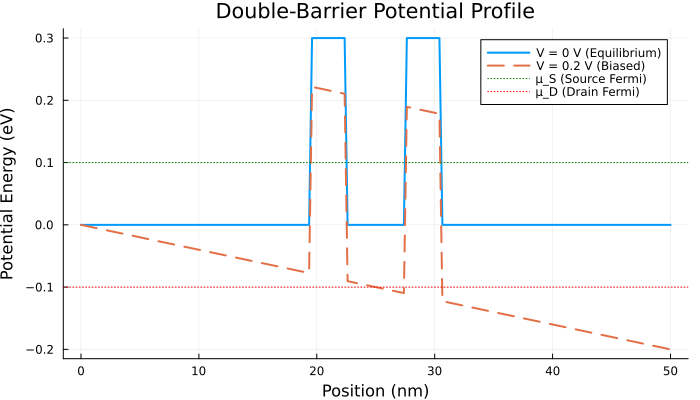

In [5]:
V_test = 0.2  # Test bias
U_biased = apply_bias(U_eq, device, V_test)

p = plot(device.x, U_eq, 
    label="V = 0 V (Equilibrium)",
    linewidth=2,
    xlabel="Position (nm)",
    ylabel="Potential Energy (eV)",
    title="Double-Barrier Potential Profile",
    legend=:topright,
    size=(700, 400)
)

plot!(p, device.x, U_biased,
    label="V = $(V_test) V (Biased)",
    linewidth=2,
    linestyle=:dash
)

# Mark Fermi levels
hline!(p, [device.E_F], label="μ_S (Source Fermi)", linestyle=:dot, color=:green)
hline!(p, [device.E_F - V_test], label="μ_D (Drain Fermi)", linestyle=:dot, color=:red)

display(p)

## Hamiltonian Construction

The device Hamiltonian $H_D$ is a tridiagonal matrix representing the tight-binding model:

$$H_D = \begin{pmatrix} 2t + U_1 & -t & 0 & \cdots \\ -t & 2t + U_2 & -t & \cdots \\ 0 & -t & 2t + U_3 & \cdots \\ \vdots & \vdots & \vdots & \ddots \end{pmatrix}$$

Julia has support for sparse vectors and sparse matrices in the SparseArrays stdlib module. Sparse arrays are arrays that contain enough zeros that storing them in a special data structure leads to savings in space and execution time, compared to dense arrays. [Julia Sparse arrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays)

Using `spdiagm` used to construct a sparse diagonal matrix from Pairs of vectors and diagonals.

In [6]:

function build_hamiltonian(U::Vector{Float64}, dev::DeviceParameters)
    N = dev.N
    t = dev.t
    
    diag_main = 2t .+ U
    
    diag_off = fill(-t, N-1)
    
    # Build sparse tridiagonal matrix
    H = spdiagm(0 => diag_main, 1 => diag_off, -1 => diag_off)
    
    return H
end

# Build and examine Hamiltonian
H_eq = build_hamiltonian(U_eq, device)

println("Hamiltonian constructed:")
println("  Size: $(size(H_eq))")
println("  Non-zero elements: $(nnz(H_eq))")
println("  Sparsity: $(round(100 * nnz(H_eq) / prod(size(H_eq)), digits=2))%")
println("\nFirst 5×5 block of H:")
display(round.(Matrix(H_eq[1:5, 1:5]), digits=4))

5×5 Matrix{Float64}:
 18.0154  -9.0077   0.0      0.0      0.0
 -9.0077  18.0154  -9.0077   0.0      0.0
  0.0     -9.0077  18.0154  -9.0077   0.0
  0.0      0.0     -9.0077  18.0154  -9.0077
  0.0      0.0      0.0     -9.0077  18.0154

Hamiltonian constructed:
  Size: (200, 200)
  Non-zero elements: 598
  Sparsity: 1.5%

First 5×5 block of H:


## Self-Energies and Broadening

The **self-energies** $\Sigma_S$ and $\Sigma_D$ encode the effect of semi-infinite leads:

$$\Sigma_S(E) = -t \exp(ik_S a), \quad k_S = \frac{\sqrt{2m^* E}}{\hbar}$$

$$\Sigma_D(E) = -t \exp(ik_D a), \quad k_D = \frac{\sqrt{2m^* (E + eV)}}{\hbar}$$

The **broadening matrices** $\Gamma$ give the coupling strength:

$$\Gamma = i(\Sigma - \Sigma^\dagger) = -2\text{Im}(\Sigma)$$

In [7]:
# SELF-ENERGY CALCULATIONS
function compute_wavevector(E::Float64, dev::DeviceParameters)
    # E = ℏ²k²/2m* → k = sqrt(2m*E)/ℏ
    if E > 0
        return sqrt(E * dev.m_eff / ħ2_over_2m0)
    else
        return im * sqrt(-E * dev.m_eff / ħ2_over_2m0)
    end
end

function compute_self_energies(E::Float64, V::Float64, dev::DeviceParameters)
    t = dev.t
    a = dev.a
    
    k_S = compute_wavevector(E, dev)
    k_D = compute_wavevector(E + V, dev)  # Drain is shifted by -eV
    
    Σ_S = -t * exp(im * k_S * a)
    Σ_D = -t * exp(im * k_D * a)
    
    Γ_S = -2 * imag(Σ_S)
    Γ_D = -2 * imag(Σ_D)
    
    return Σ_S, Σ_D, Γ_S, Γ_D
end

# Test self-energies at E = 0.1 eV
E_test = 0.1
Σ_S, Σ_D, Γ_S, Γ_D = compute_self_energies(E_test, 0.0, device)

(-8.957757358503686 - 0.9473345283982704im, -8.957757358503686 - 0.9473345283982704im, 1.8946690567965407, 1.8946690567965407)

## Retarded Green's Function

The **retarded Green's function** is the central object in NEGF,

$$G^R(E) = [E \cdot I - H_D - \Sigma_S - \Sigma_D]^{-1}$$

For the transmission, we only need $G^R_{1,N}$ connecting source to drain.

In [8]:
# Compute the retarded Green's function by direct matrix inversion.
# This is the straightforward but computationally expensive method.
# Returns G^R as a dense matrix.
function compute_greens_function_direct(E::Float64, H::SparseMatrixCSC, 
                                        Σ_S::ComplexF64, Σ_D::ComplexF64)
    N = size(H, 1)

    η = 1e-9
    A = (E + im*η) * I - H
    A = Matrix(A)
    
    A[1, 1] -= Σ_S
    A[N, N] -= Σ_D
    
    G_R = inv(A)
    
    return G_R
end


H_test = build_hamiltonian(U_eq, device)
Σ_S, Σ_D, _, _ = compute_self_energies(0.1, 0.0, device)

G_R_full = compute_greens_function_direct(0.1, H_test, Σ_S, Σ_D)
G_1N_direct = G_R_full[1, end]

println("Green's function G_{1,N} at E = 0.1 eV:")
println("  |G_{1,N}| = $(abs(G_1N_direct))")

Green's function G_{1,N} at E = 0.1 eV:
  |G_{1,N}| = 0.11939988302500185


## Transmission Function

$T(E)$ gives the probability of an electron at energy $E$ tunneling from source to drain,

$$T(E) = \Gamma_S |G^R_{1,N}|^2 \Gamma_D$$

At resonance $T(E) \approx 1$.

In [9]:
function compute_transmission(E::Float64, V::Float64, dev::DeviceParameters,
                              H::SparseMatrixCSC)
    # Skip if energy is below band edge
    if E < 0 || E + V < 0
        return 0.0
    end
    
    # Compute self-energies and broadening
    Σ_S, Σ_D, Γ_S, Γ_D = compute_self_energies(E, V, dev)
    
    # Compute Green's function
    G_R = compute_greens_function_direct(E, H, Σ_S, Σ_D)
    G_1N = G_R[1, end]
    
    # Transmission: T = Γ_S * |G_{1,N}|² * Γ_D
    T = Γ_S * abs2(G_1N) * Γ_D
    
    return max(0.0, min(1.0, T))  # Clamp to [0, 1] (it's a probability)
end

function compute_transmission_spectrum(E_range, V::Float64, dev::DeviceParameters)
    U_eq = create_equilibrium_potential(dev)
    U_V = apply_bias(U_eq, dev, V)
    H_V = build_hamiltonian(U_V, dev)
    
    T_spectrum = zeros(length(E_range))
    
    for (i, E) in enumerate(E_range)
        T_spectrum[i] = compute_transmission(E, V, dev, H_V)
    end
    
    return T_spectrum
end

compute_transmission_spectrum (generic function with 1 method)

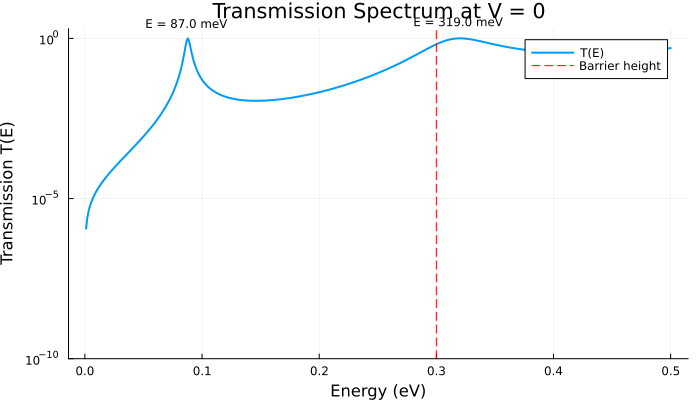


Resonant energies (T > 0.1):
  E = 87.0 meV, T = 0.8793
  E = 319.0 meV, T = 0.9985


In [10]:
# Compute and plot transmission spectrum at equilibrium
E_range = range(0.001, 0.5, length=500)
T_eq = compute_transmission_spectrum(E_range, 0.0, device)

# Find peaks
peak_idx = findall(i -> T_eq[i] > 0.1 && T_eq[i] > T_eq[i-1] && T_eq[i] > T_eq[i+1], 
                   2:length(T_eq)-1)

p = plot(E_range, T_eq,
    xlabel="Energy (eV)",
    ylabel="Transmission T(E)",
    title="Transmission Spectrum at V = 0",
    label="T(E)",
    linewidth=2,
    yscale=:log10,
    ylims=(1e-10, 2),
    size=(700, 400)
)

# Mark barrier height
vline!(p, [device.barrier_height], label="Barrier height", linestyle=:dash, color=:red)

# Annotate resonances
if !isempty(peak_idx)
    for idx in peak_idx[1:min(3, length(peak_idx))]
        annotate!(p, E_range[idx], T_eq[idx] * 2, 
                  text("E = $(round(E_range[idx]*1000, digits=1)) meV", 8, :bottom))
    end
end

display(p)

println("\nResonant energies (T > 0.1):")
for idx in peak_idx
    println("  E = $(round(E_range[idx]*1000, digits=2)) meV, T = $(round(T_eq[idx], digits=4))")
end

## Current Calculation (Landauer-Büttiker Formula)

The current is computed using the Landauer-Büttiker formula, 

$$I(V) = \frac{2e}{h} \int_{-\infty}^{+\infty} T(E, V) [f_S(E) - f_D(E)] \, dE$$

where the Fermi-Dirac distributions are,
$$f_S(E) = \frac{1}{1 + \exp((E - \mu_S)/k_B T)}$$
$$f_D(E) = \frac{1}{1 + \exp((E - \mu_D)/k_B T)}$$

with $\mu_S = E_F$ and $\mu_D = E_F - eV$.

In [11]:
function fermi_dirac(E::Float64, μ::Float64, T::Float64)
    kT = kB_eV * T
    x = (E - μ) / kT

    return 1.0 / (1.0 + exp(x))
end

function compute_current(V::Float64, dev::DeviceParameters; E_min::Float64=0.001, E_max::Float64=0.5, n_points::Int=300)
    E_range = range(E_min, E_max, length=n_points)
    dE = step(E_range)
    
    μ_S = dev.E_F
    μ_D = dev.E_F - V
    
    U_eq = create_equilibrium_potential(dev)
    U_V = apply_bias(U_eq, dev, V)
    H_V = build_hamiltonian(U_V, dev)
    

    # DISCRETE SUM
    current_sum = 0.0
    
    for E in E_range
        T_E = compute_transmission(E, V, dev, H_V)
        f_S = fermi_dirac(E, μ_S, dev.T)
        f_D = fermi_dirac(E, μ_D, dev.T)
        
        current_sum += T_E * (f_S - f_D) * dE
    end
    
    # Prefactor gives Amperes
    prefactor = 2 * e_SI / (2π * ħ_SI)
    
    I = prefactor * current_sum
    
    return I
end

I_test = compute_current(0.1, device)
println("Test current at V = 0.1 V: I = $(round(I_test * 1e6, digits=4)) μA")

Test current at V = 0.1 V: I = 2.7188569505328947e18 μA


## I-V Characteristic Simulation

Now we sweep the bias voltage to generate the full I-V characteristic.

In [60]:
# I-V SIMULATION
function simulate_iv_curve(dev::DeviceParameters; 
                           V_max::Float64=0.4, n_voltage::Int=50)
    V_array = collect(range(0.001, V_max, length=n_voltage))
    I_array = zeros(n_voltage)
    
    println("Simulating I-V curve...")
    println("  Voltage range: 0 to $(V_max) V")
    println("  Number of points: $(n_voltage)")
    
    for (i, V) in enumerate(V_array)
        I_array[i] = compute_current(V, dev)
    end

    return V_array, I_array
end

println("I-V simulation function defined.")

I-V simulation function defined.


In [13]:
# Run the I-V simulation
@time V_data, I_data = simulate_iv_curve(device, V_max=0.3, n_voltage=40)

Simulating I-V curve...
  Voltage range: 0 to 0.3 V
  Number of points: 40
finished calculating
205.261960 seconds (326.25 k allocations: 16.928 GiB, 1.78% gc time)


([0.001, 0.008666666666666666, 0.01633333333333333, 0.024, 0.03166666666666667, 0.03933333333333333, 0.047, 0.05466666666666667, 0.06233333333333333, 0.07  …  0.231, 0.23866666666666667, 0.24633333333333332, 0.254, 0.26166666666666666, 0.2693333333333333, 0.277, 0.2846666666666667, 0.29233333333333333, 0.3], [3.346408099548779e10, 2.894534985655966e11, 5.432806106551387e11, 7.921896360220297e11, 1.0341110671700834e12, 1.268573754422584e12, 1.492792976738921e12, 1.704504436412588e12, 1.905333675167603e12, 2.094267787808713e12  …  1.6568566244084954e12, 1.7971273444645789e12, 1.9580086806155042e12, 2.1400375662290237e12, 2.3442917803424404e12, 2.5721929662782095e12, 2.825396584168874e12, 3.10572088519648e12, 3.415093237731253e12, 3.7555031733990107e12])

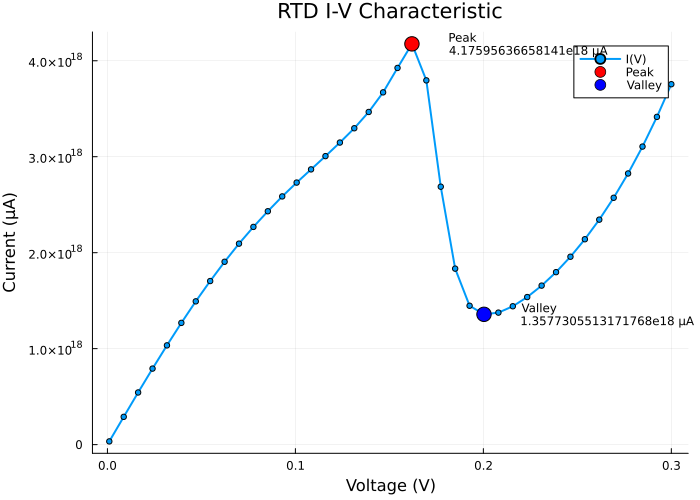

In [59]:
# Convert to μA for plotting
I_uA = I_data .* 1e6

# Find peak and valley
peak_idx = argmax(I_uA)

V_peak = V_data[peak_idx]
I_peak = I_uA[peak_idx]


post_peak_indices = peak_idx:length(I_uA)
post_peak_currents = I_uA[post_peak_indices]

# Start looking for the valley starting from the peak
valley_idx = argmin(post_peak_currents) + peak_idx - 1

V_valley = V_data[valley_idx]
I_valley = I_uA[valley_idx]

p = plot(V_data, I_uA,
    xlabel="Voltage (V)",
    ylabel="Current (μA)",
    title="RTD I-V Characteristic",
    label="I(V)",
    linewidth=2,
    marker=:circle,
    markersize=3,
    size=(700, 500),
    legend=:topright
)

# Mark peak and valley
scatter!(p, [V_peak], [I_peak], label="Peak", markersize=8, color=:red)
scatter!(p, [V_valley], [I_valley], label="Valley", markersize=8, color=:blue)

# Add annotations
annotate!(p, V_peak + 0.02, I_peak, text("Peak\n$(round(I_peak, digits=2)) μA", 8, :left))
annotate!(p, V_valley + 0.02, I_valley, text("Valley\n$(round(I_valley, digits=2)) μA", 8, :left))

display(p)

## Transmission vs Voltage Analysis

The resonant peak moves relative to the transport window defined by $[\mu_D, \mu_S]$.

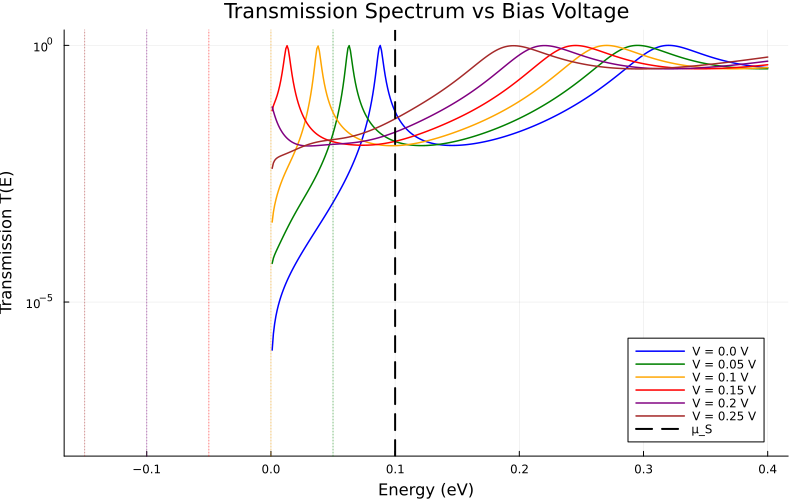

In [ ]:
# Compute transmission spectra at different voltages
E_range = range(0.001, 0.4, length=400)
voltages = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]

p = plot(
    xlabel="Energy (eV)",
    ylabel="Transmission T(E)",
    title="Transmission Spectrum vs Bias Voltage",
    yscale=:log10,
    ylims=(1e-8, 2),
    size=(800, 500),
    legend=:bottomright
)

colors = [:blue, :green, :orange, :red, :purple, :brown]

for (i, V) in enumerate(voltages)
    T_V = compute_transmission_spectrum(E_range, V, device)
    
    plot!(p, E_range, T_V,
        label="V = $(V) V",
        linewidth=1.5,
        color=colors[i]
    )
    
    μ_S = device.E_F
    μ_D = device.E_F - V
    if V > 0
        vline!(p, [μ_D], linestyle=:dot, color=colors[i], label="", alpha=0.5)
    end
end

vline!(p, [device.E_F], linestyle=:dash, color=:black, label="μ_S", linewidth=2)

display(p)

## Parameter Study
A look into how device parameters affect the I-V characteristic.

### **Barrier height**: Higher barriers give sharper resonances

Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating


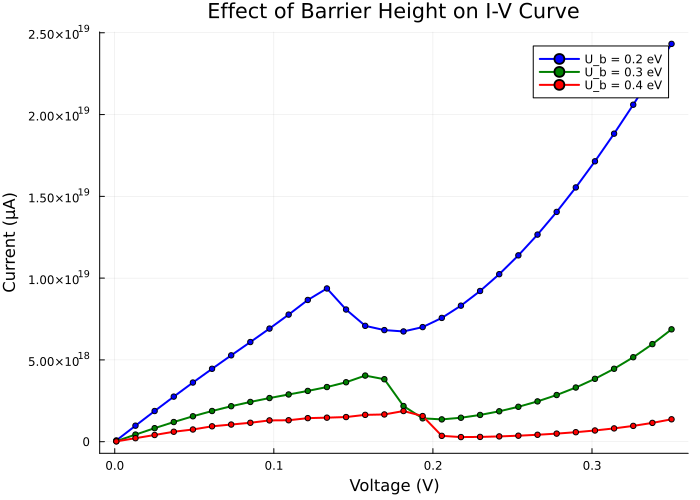

In [ ]:
barrier_heights = [0.2, 0.3, 0.4]  # eV

p = plot(
    xlabel="Voltage (V)",
    ylabel="Current (μA)",
    title="Effect of Barrier Height on I-V Curve",
    size=(700, 500),
    legend=:topright
)

colors = [:blue, :green, :red]

for (i, U_b) in enumerate(barrier_heights)
    dev_temp = DeviceParameters(barrier_height=U_b)
    V_temp, I_temp = simulate_iv_curve(dev_temp, V_max=0.35, n_voltage=30)
    
    plot!(p, V_temp, I_temp .* 1e6,
        label="U_b = $(U_b) eV",
        linewidth=2,
        marker=:circle,
        markersize=3,
        color=colors[i]
    )
end

display(p)

### **Barrier width**: Thicker barriers give narrower resonances and lower current

Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating


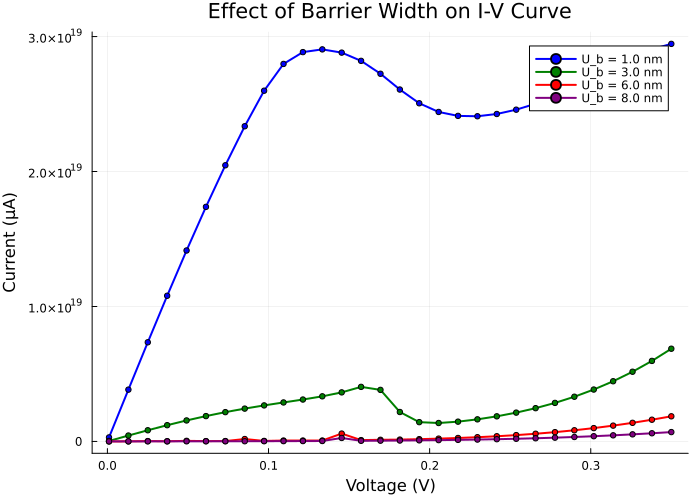

In [25]:
barrier_widths = [1.0, 3.0, 6.0, 8.0]  # eV

p = plot(
    xlabel="Voltage (V)",
    ylabel="Current (μA)",
    title="Effect of Barrier Width on I-V Curve",
    size=(700, 500),
    legend=:topright
)

colors = [:blue, :green, :red, :purple]

for (i, U_b) in enumerate(barrier_widths)
    dev_temp = DeviceParameters(barrier_width=U_b)
    V_temp, I_temp = simulate_iv_curve(dev_temp, V_max=0.35, n_voltage=30)
    
    plot!(p, V_temp, I_temp .* 1e6,
        label="U_b = $(U_b) nm",
        linewidth=2,
        marker=:circle,
        markersize=3,
        color=colors[i]
    )
end

display(p)

### **Well width**: Wider well deliver a lower resonant energy, different peak voltage

Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating
Simulating I-V curve...
  Voltage range: 0 to 0.35 V
  Number of points: 30
finished calculating


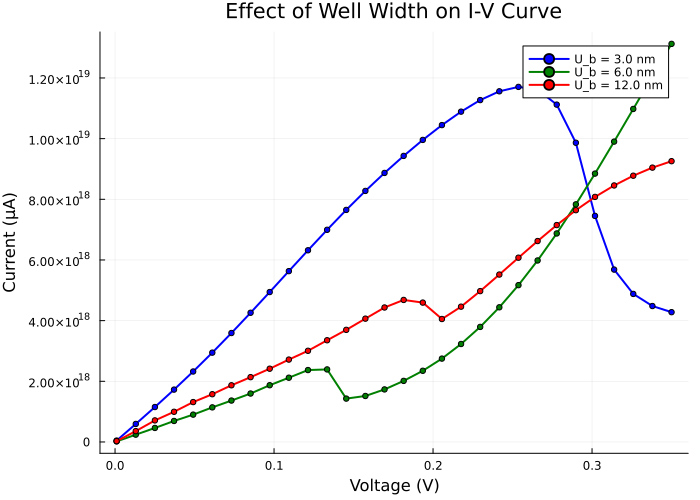

In [28]:
well_widths = [3.0, 6.0, 12.0]  # eV

p = plot(
    xlabel="Voltage (V)",
    ylabel="Current (μA)",
    title="Effect of Well Width on I-V Curve",
    size=(700, 500),
    legend=:topright
)

colors = [:blue, :green, :red, :purple]

for (i, U_b) in enumerate(well_widths)
    dev_temp = DeviceParameters(well_width=U_b)
    V_temp, I_temp = simulate_iv_curve(dev_temp, V_max=0.35, n_voltage=30)
    
    plot!(p, V_temp, I_temp .* 1e6,
        label="U_b = $(U_b) nm",
        linewidth=2,
        marker=:circle,
        markersize=3,
        color=colors[i]
    )
end

display(p)

## local density of states (LDOS)

The **local density of states (LDOS)** shows where electrons can exist in the device:
$$A(x, E) = -\frac{1}{\pi} \text{Im}[G^R_{xx}(E)]$$
This reveals the quasi-bound states in the quantum well.

In [ ]:
function compute_ldos(E_range, V::Float64, dev::DeviceParameters)
    N = dev.N
    n_E = length(E_range)
    
    LDOS = zeros(N, n_E)
    
    U_eq = create_equilibrium_potential(dev)
    U_V = apply_bias(U_eq, dev, V)
    H_V = build_hamiltonian(U_V, dev)
    
    for (j, E) in enumerate(E_range)
        if E < 0 || E + V < 0
            continue
        end
        
        Σ_S, Σ_D, _, _ = compute_self_energies(E, V, dev)
        G_R = compute_greens_function_direct(E, H_V, Σ_S, Σ_D)
        
        # LDOS = -Im(G_ii)/π
        for i in 1:N
            LDOS[i, j] = -imag(G_R[i, i]) / π
        end
    end
    
    return LDOS
end

E_ldos = range(0.01, 0.35, length=100)
@time LDOS = compute_ldos(E_ldos, 0.1, device)

Computing LDOS (this may take a moment)...
  0.520267 seconds (26.04 k allocations: 145.768 MiB, 8.53% gc time, 8.30% compilation time)
Done!


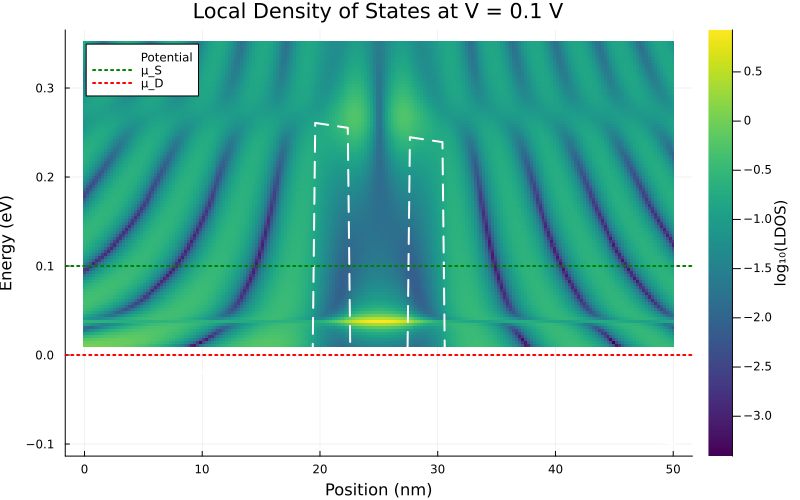

In [ ]:
# Plot LDOS as heatmap
U_V_plot = apply_bias(create_equilibrium_potential(device), device, 0.1)

p = heatmap(device.x, collect(E_ldos), log10.(LDOS' .+ 1e-10),
    xlabel="Position (nm)",
    ylabel="Energy (eV)",
    title="Local Density of States at V = 0.1 V",
    colorbar_title="log₁₀(LDOS)",
    size=(800, 500),
    c=:viridis
)

# Overlay potential profile
plot!(p, device.x, U_V_plot,
    label="Potential",
    color=:white,
    linewidth=2,
    linestyle=:dash
)

hline!(p, [device.E_F], color=:green, linewidth=2, linestyle=:dot, label="μ_S")
hline!(p, [device.E_F - 0.1], color=:red, linewidth=2, linestyle=:dot, label="μ_D")

display(p)

---

## References

Look in `references.bib`
And `RTD_NEGF_Julia.pdf`